# Metapath-visits HGCN


In [1]:
import numpy as np
from torch_geometric.utils.convert import from_networkx
from sklearn.model_selection import train_test_split
import networkx as nx 


In [15]:

G = nx.read_gml('Data/HGs/HG1.gml')

VisitsLOS = {}
for node in G.nodes:
    if node[0]=='V':
        VisitsLOS[node] = G.nodes[node]['LOS']
VisitsLOS


{'V_181711': 6,
 'V_130744': 7,
 'V_133550': 1,
 'V_108732': 4,
 'V_103002': 8,
 'V_137006': 8,
 'V_188038': 8,
 'V_111199': 7,
 'V_126219': 2,
 'V_197296': 3,
 'V_135879': 8,
 'V_191596': 19,
 'V_142160': 9,
 'V_172752': 19,
 'V_189928': 5,
 'V_176225': 16,
 'V_194975': 24,
 'V_151107': 8,
 'V_190712': 6,
 'V_147743': 23,
 'V_174792': 15,
 'V_188758': 4,
 'V_199523': 16,
 'V_127896': 2,
 'V_139338': 12,
 'V_108607': 5,
 'V_123703': 17,
 'V_101462': 5,
 'V_104742': 10,
 'V_165018': 5,
 'V_142815': 16,
 'V_118027': 0,
 'V_191863': 9,
 'V_113376': 5,
 'V_185858': 16,
 'V_100940': 2,
 'V_193606': 5,
 'V_162975': 16,
 'V_164903': 8,
 'V_181345': 4,
 'V_158667': 3,
 'V_189459': 7,
 'V_115497': 21,
 'V_195382': 24,
 'V_135491': 26,
 'V_112903': 7,
 'V_101005': 14,
 'V_122084': 1,
 'V_188017': 15,
 'V_190997': 14,
 'V_135108': 1,
 'V_194292': 7,
 'V_163234': 1,
 'V_126559': 6,
 'V_178419': 13,
 'V_181012': 3,
 'V_170769': 14,
 'V_152495': 6,
 'V_160961': 8,
 'V_166923': 4,
 'V_107796': 10,
 '

In [16]:
len(VisitsLOS)

1171

In [17]:
import pickle

filename = "Data/symmetricPath/data.pickle"

with open(filename, 'rb') as file:
    loaded_array = pickle.load(file)

with open('Data/symmetricPath/visits.pickle', 'rb') as file:
    visits = pickle.load(file)

len(visits)

1171

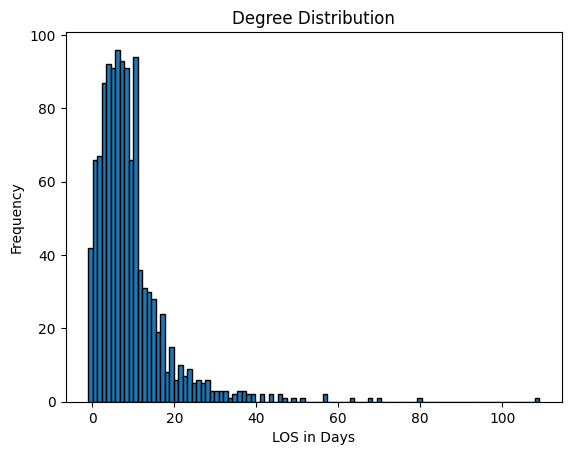

In [18]:
import matplotlib.pyplot as plt
degrees = [G.nodes[node]['LOS'] for node in G.nodes if G.nodes[node]['LOS']!=99999]
# Create a histogram
plt.hist(degrees, bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('LOS in Days')
plt.ylabel('Frequency')
plt.title('Degree Distribution')

# Show the plot
plt.show()

In [4]:
X = np.random.randn(len(list(G.nodes())), 128)

for i, node in enumerate(list(G.nodes())):
    G.nodes[node]['x'] = X[i]

for i, node in enumerate(list(G.nodes())):
    if G.nodes[node]['LOS']<=5:
        G.nodes[node]['LOS']=0
    if G.nodes[node]['LOS']>5:
        G.nodes[node]['LOS']=1


In [5]:
data = from_networkx(G)

c:\Anaconda3\envs\GNNenv\Lib\site-packages\torch_geometric\utils\convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  data[key] = torch.tensor(value)


In [6]:
data['y'] = data.pop('LOS')
data

Data(x=[2821, 128], edge_index=[2, 7955220], weight=[7955220], y=[2821])

## Creating new masks out of patient nodes only

In [7]:
newY = []
total = 0
for i,v in enumerate(list(data.y)):
    if v!=99999:
        newY.append([i,v])
        total+=1

y_train, y_left = train_test_split(newY    , train_size=0.7, random_state=42)
y_val,   y_test = train_test_split(y_left  , test_size=2/3, random_state=42)

# Create masks for train, validation, and test sets
train_mask = np.zeros(len(data.y), dtype=bool)
val_mask = np.zeros(len(data.y), dtype=bool)
test_mask = np.zeros(len(data.y), dtype=bool)

for i,v in y_train:
    train_mask[i] = True

for i,v in y_val:
    val_mask[i] = True

for i, v in y_test:
    test_mask[i] = True

print(train_mask.shape)
print(val_mask.shape)
print(test_mask.shape)
print('Train = ', sum([1 if v else 0 for v in train_mask])/total)
print('Val = ', sum([1 if v else 0 for v in val_mask])/total)
print('Test = ', sum([1 if v else 0 for v in test_mask])/total)

(2821,)
(2821,)
(2821,)
Train =  0.6997518610421837
Val =  0.0999645515774548
Test =  0.20028358738036156


In [8]:
data.train_mask = train_mask
data.test_mask  = test_mask
data.val_mask   = val_mask

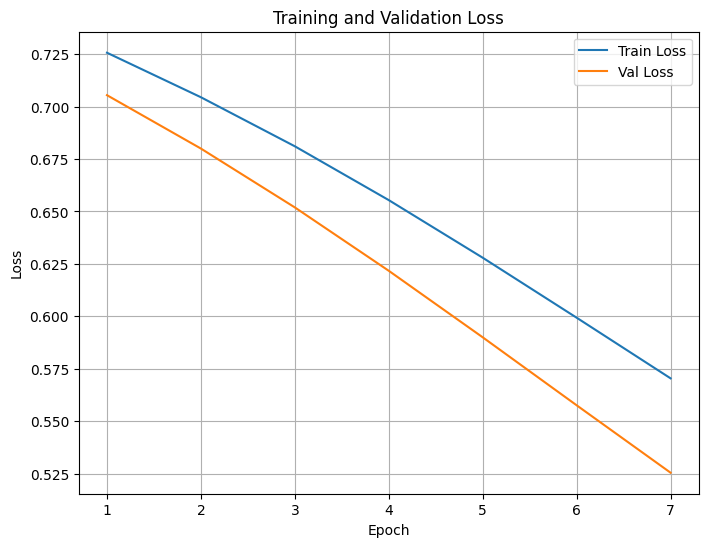

[[  0  90]
 [  0 475]]
F1 score =  0.4567307692307692
Precision score =  0.42035398230088494
AUC Precision score =  0.8407079646017699


c:\Anaconda3\envs\GNNenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Acc: 0.841



In [9]:
import GNNModel as GNNM
import torch

data.x = data.x.float()
data.y = data.y.long()
num_classes = 2

# Check if a GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = data.to(device)
gcn = GNNM.SAGE(data.num_node_features, num_classes).to(device)

optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
gcn, df = GNNM.train_node_classifier(gcn, data, optimizer_gcn, criterion, n_epochs=7)

GNNM.plt_performance(df)
# ----------------------------------------------------------------------------
pred = gcn(data).argmax(dim=1)

pred = pred[data.test_mask] .detach().cpu().numpy()
correct = data.y[data.test_mask].detach().cpu().numpy()

GNNM.create_confusion_matrix(pred, correct)


test_acc, _ = GNNM.eval_node_classifier(gcn, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}\n')

In [10]:
# import GNNModel as GNNM
# import torch

# data.x = data.x.float()
# data.y = data.y.float()

# # Check if a GPU is available, otherwise use CPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data = data.to(device)
# gcn = GNNM.GCNRegression(data.num_node_features).to(device)

# optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
# # criterion = torch.nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
# gcn, df = GNNM.train_node_classifier(gcn, data, optimizer_gcn, criterion, n_epochs=25)
# # ----------------------------------------------------------------------------

# pred = gcn(data).argmax(dim=1)

# pred = pred[data.test_mask] .detach().cpu().numpy()
# correct = data.y[data.test_mask].detach().cpu().numpy()

# [(pred[i], correct[i]) for i in range(len(correct))]

# import matplotlib.pyplot as plt

# # Assuming you have already defined 'pred' and 'correct'

# # Create a scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(correct, pred, c='blue', alpha=0.6, edgecolors='k')

# # Add labels and title
# plt.xlabel('Actual Values (correct)')
# plt.ylabel('Predicted Values (pred)')
# plt.title('Predicted vs. Actual Values')

# # Add a diagonal line for reference (perfect prediction)
# plt.plot([min(correct), max(correct)], [min(correct), max(correct)], linestyle='--', color='red', linewidth=2)
# plt.legend()
# # Show the plot
# plt.show()


# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np

# # Actual target values (ground truth)
# actual_values = correct

# # Predicted values from your regression model
# predicted_values = pred

# # Calculate and print Mean Absolute Error (MAE)
# mae = mean_absolute_error(actual_values, predicted_values)
# print(f"Mean Absolute Error (MAE): {mae:.2f}")

# # Calculate and print Mean Squared Error (MSE)
# mse = mean_squared_error(actual_values, predicted_values)
# print(f"Mean Squared Error (MSE): {mse:.2f}")

# # Calculate and print Root Mean Squared Error (RMSE)
# rmse = np.sqrt(mse)
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# # Calculate and print R-squared (R²)
# r_squared = r2_score(actual_values, predicted_values)
# print(f"R-squared (R²): {r_squared:.2f}")


# # GNNM.create_confusion_matrix(pred, correct)


# # test_acc, _ = GNNM.eval_node_classifier(gcn, data, data.test_mask)
# # print(f'Test Acc: {test_acc:.3f}\n')